# **ML SPARK Competition Solution**

# Bank Marketing Prediction Model

In [25]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Set random seed for reproducibility
np.random.seed(42)

## 1. Load and Explore Data

In [27]:
print("Loading datasets...")
train_df = pd.read_csv('/content/ml-spark/train.csv')
test_df = pd.read_csv('/content/ml-spark/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Loading datasets...
Training data shape: (31647, 18)
Test data shape: (9042, 17)


## 2. Initial Data Exploration

In [29]:
print("\nFirst few rows of training data:")
display(train_df.head())


First few rows of training data:


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,21740,30,admin.,married,secondary,no,4,no,no,unknown,7,may,172,8,-1,0,unknown,0
1,22648,32,technician,single,secondary,no,116,yes,no,cellular,20,aug,718,2,-1,0,unknown,1
2,31793,56,housemaid,married,primary,no,82,no,no,unknown,16,may,215,1,-1,0,unknown,0
3,21439,25,services,single,secondary,no,333,no,yes,cellular,15,jul,1056,2,-1,0,unknown,1
4,70323,38,services,married,secondary,no,393,no,no,unknown,18,jun,90,3,-1,0,unknown,0


In [30]:
# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())


Missing values in training data:
id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64


In [31]:
print("\nMissing values in test data:")
print(test_df.isnull().sum())


Missing values in test data:
id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64


In [32]:
# Data types overview
print("\nData types in training set:")
print(train_df.dtypes)


Data types in training set:
id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target        int64
dtype: object


In [33]:
# Target distribution
print("\nTarget distribution in training set:")
print(train_df['Target'].value_counts())
print(f"Target distribution percentage: {train_df['Target'].value_counts(normalize=True) * 100}")


Target distribution in training set:
Target
0    27900
1     3747
Name: count, dtype: int64
Target distribution percentage: Target
0    88.160015
1    11.839985
Name: proportion, dtype: float64


## 3. Exploratory Data Analysis

In [34]:
# Create a function for plotting categorical features
def plot_categorical_features(df, features, target='Target'):
    plt.figure(figsize=(15, len(features)*4))
    for i, feature in enumerate(features, 1):
        plt.subplot(len(features), 1, i)
        sns.countplot(x=feature, hue=target, data=df)
        plt.title(f'Distribution of {feature} by Target')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [35]:
# Create a function for plotting numerical features
def plot_numerical_features(df, features, target='Target'):
    plt.figure(figsize=(15, len(features)*4))
    for i, feature in enumerate(features, 1):
        plt.subplot(len(features), 1, i)
        for target_val in df[target].unique():
            sns.kdeplot(df[df[target] == target_val][feature], label=f'Target={target_val}')
        plt.title(f'Distribution of {feature} by Target')
        plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
# Identify categorical and numerical features
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
num_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


Plotting categorical features distribution...


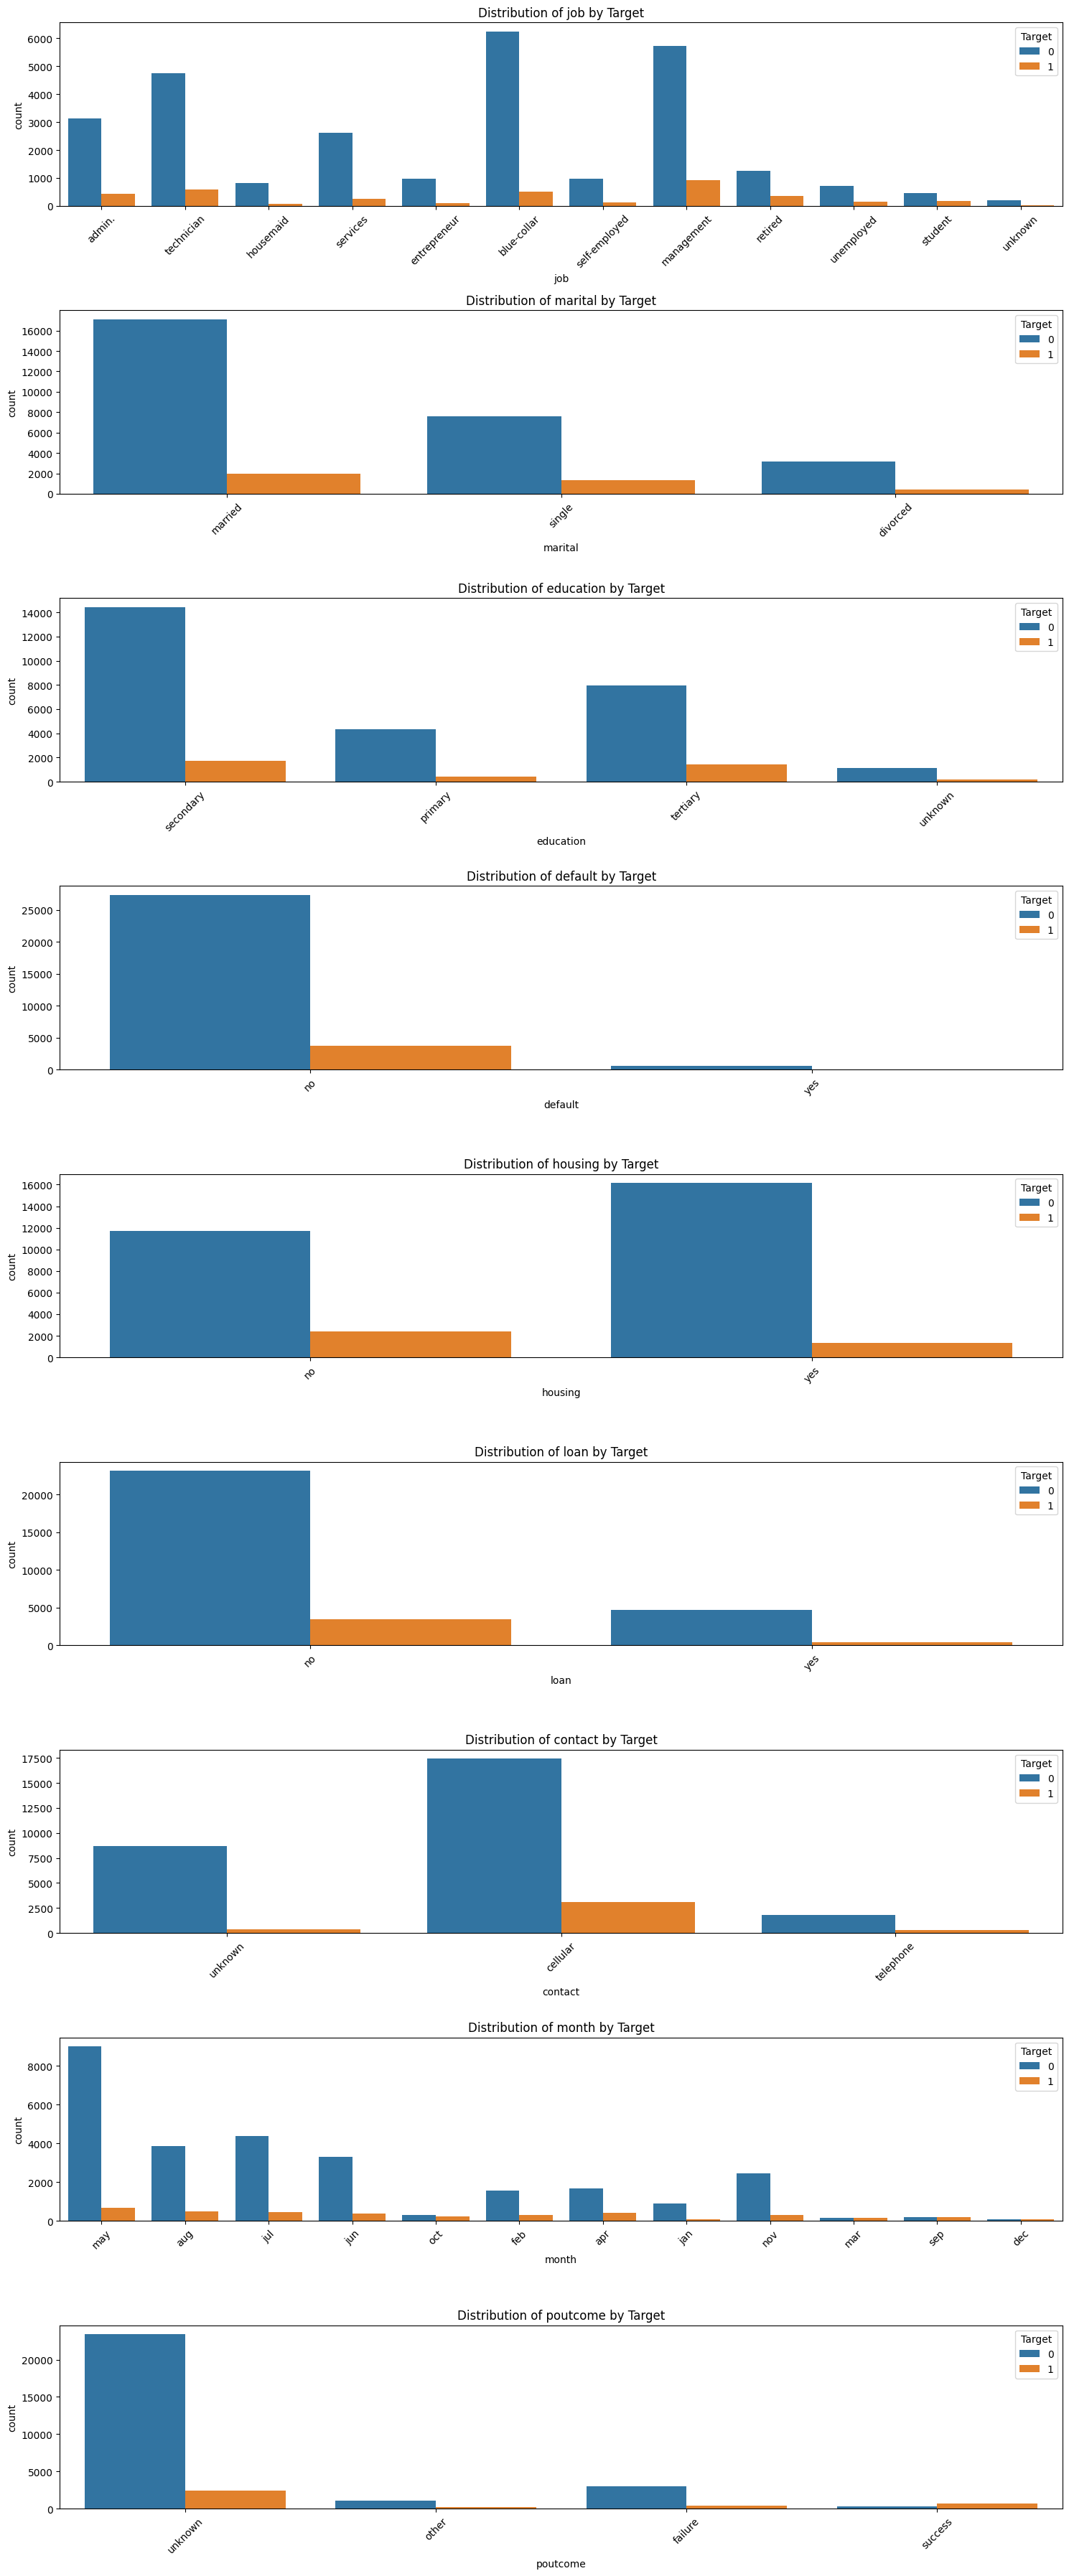

In [37]:
# Plot distributions
print("\nPlotting categorical features distribution...")
plot_categorical_features(train_df, cat_features)


Plotting numerical features distribution...


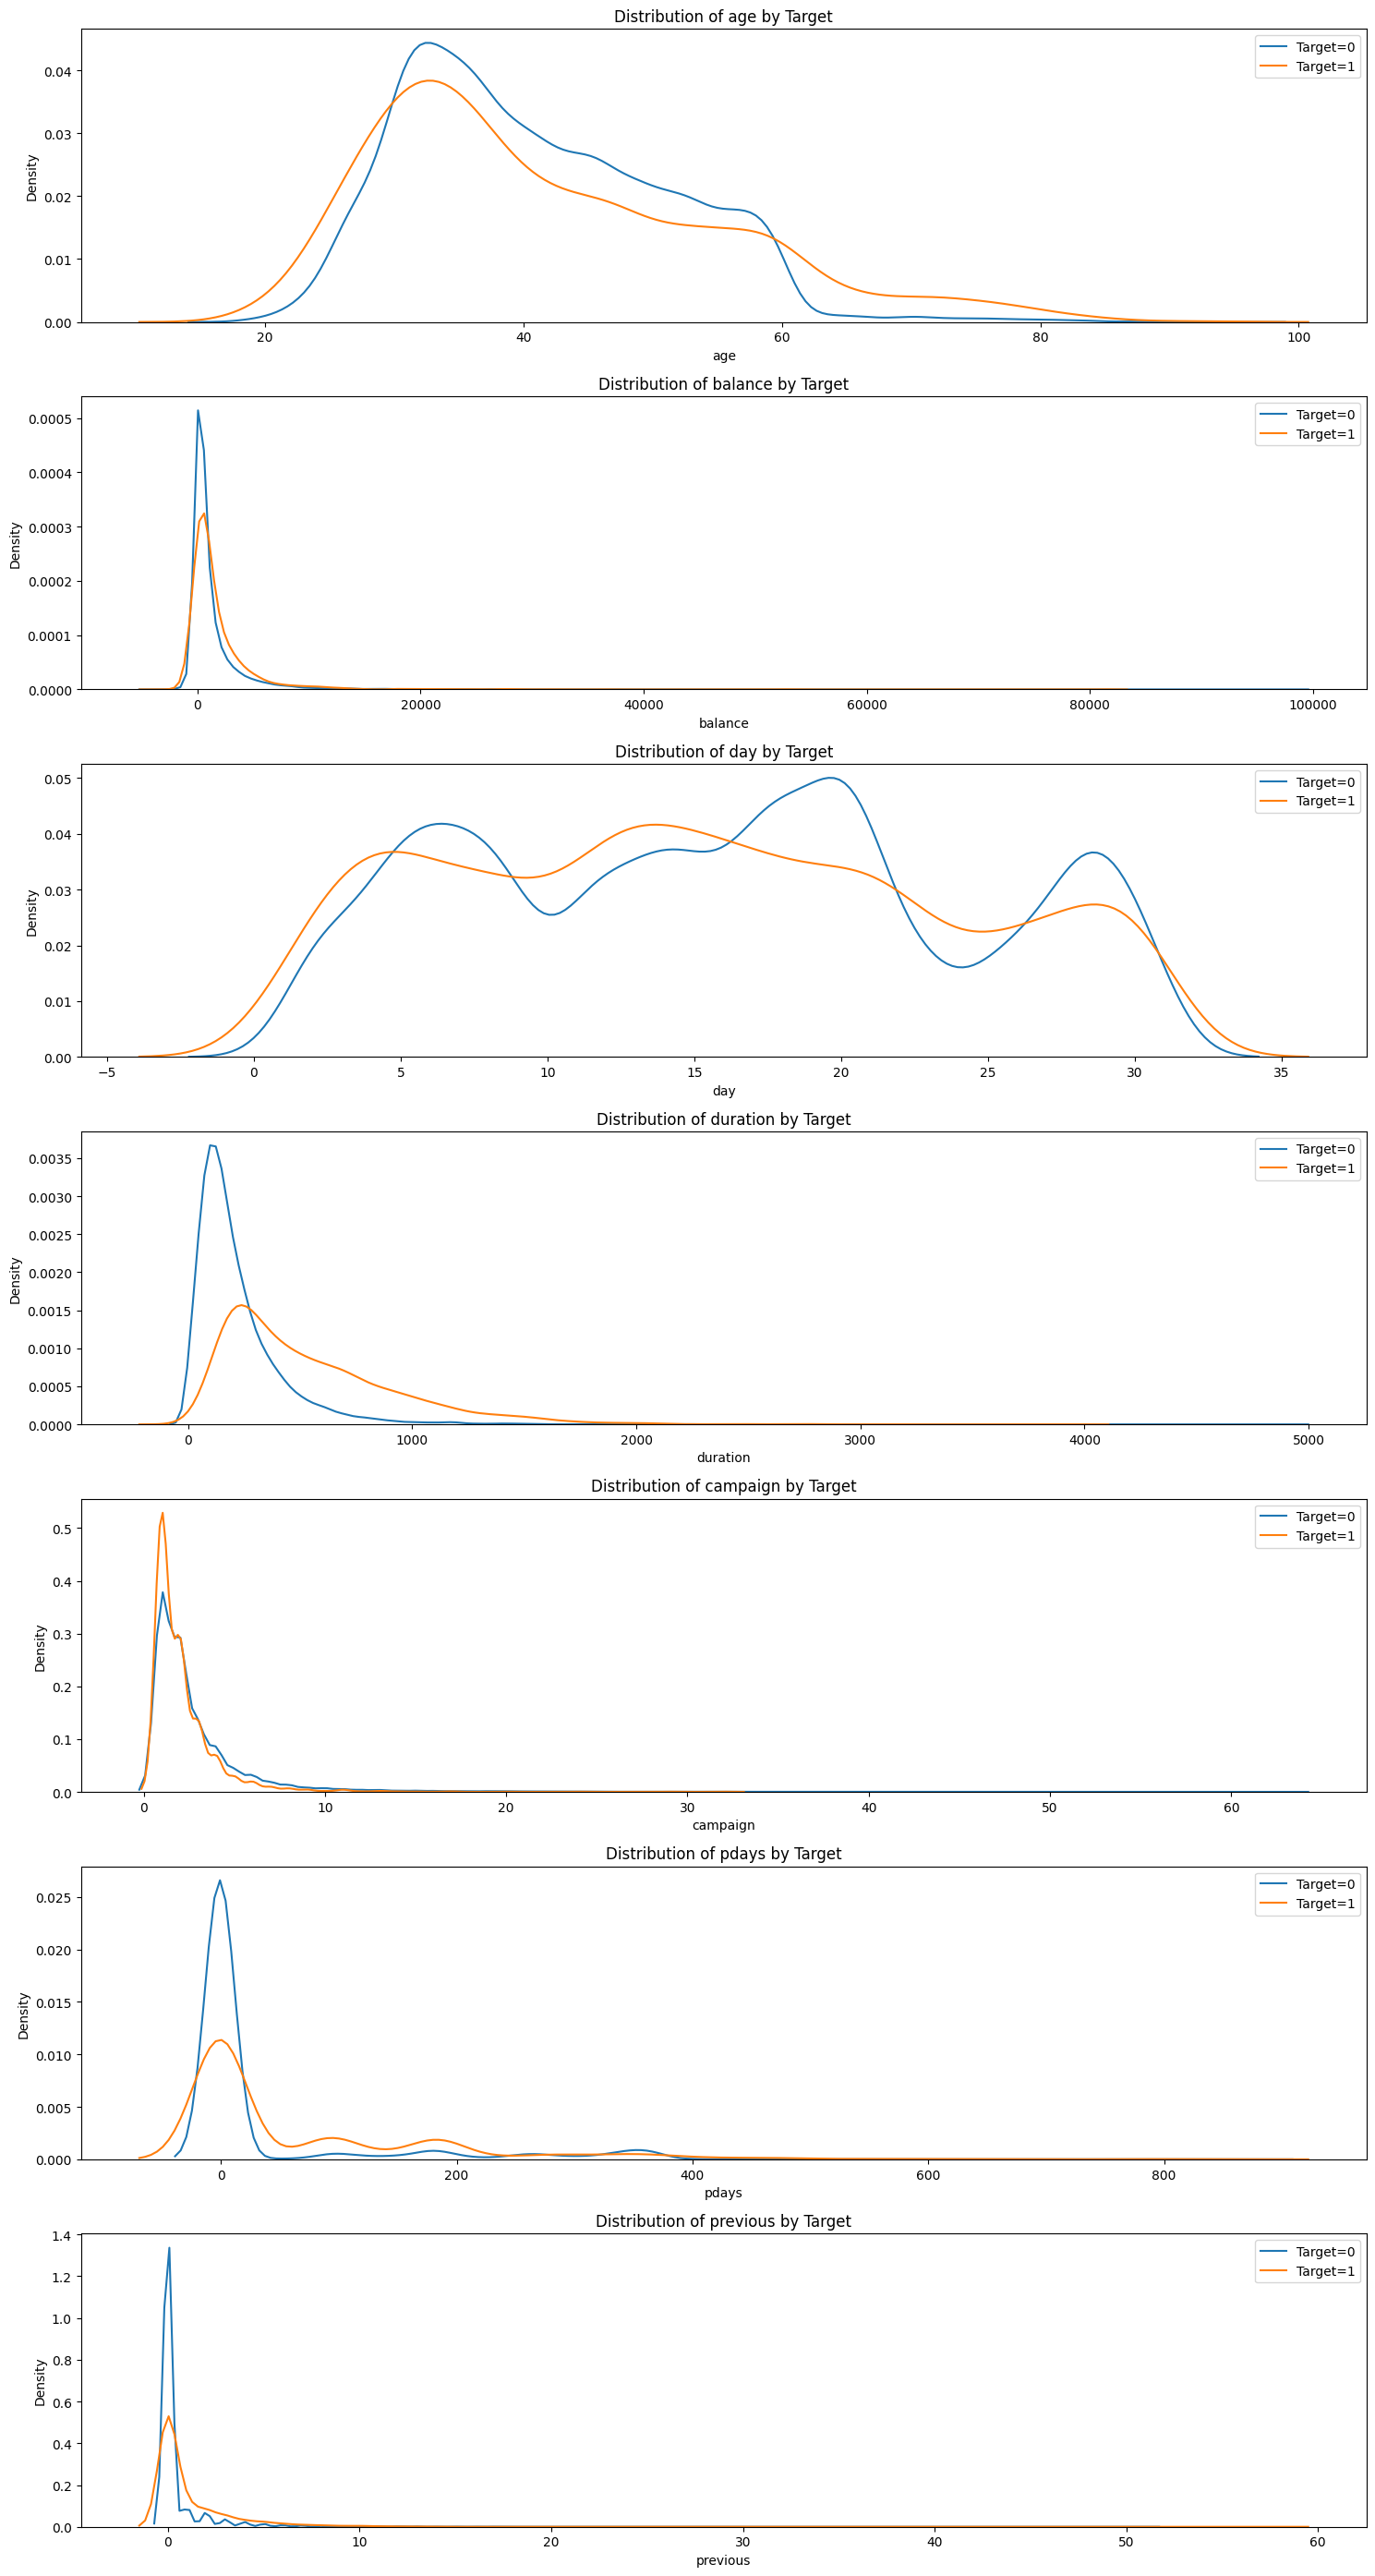

In [38]:
print("\nPlotting numerical features distribution...")
plot_numerical_features(train_df, num_features)

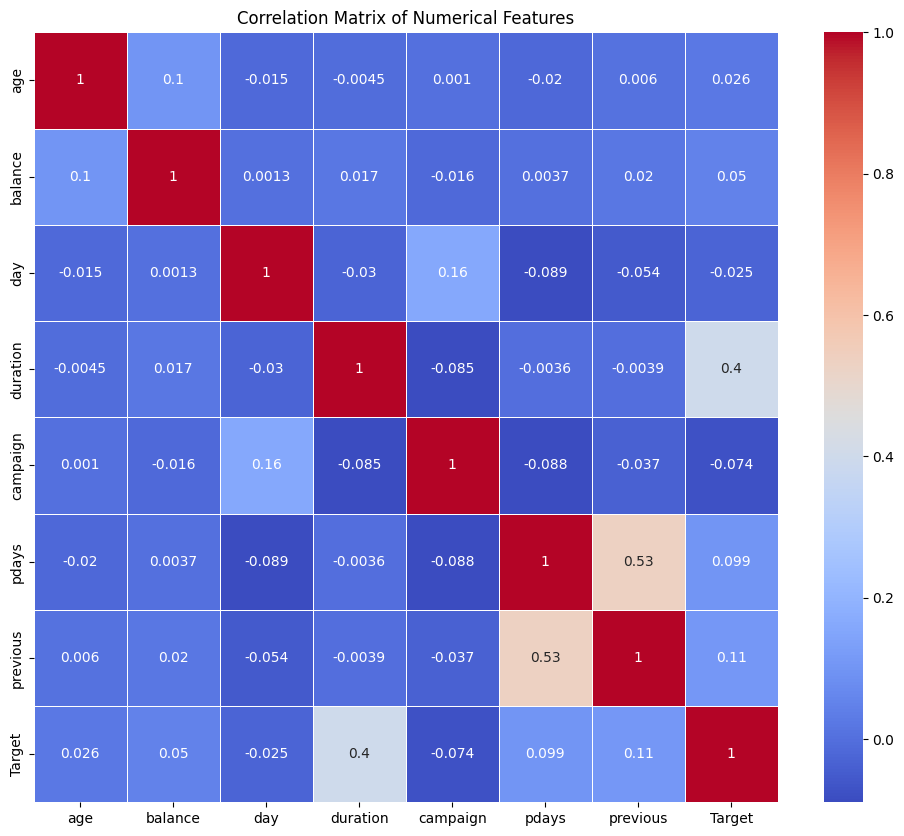

In [39]:
# Correlation analysis for numerical features
plt.figure(figsize=(12, 10))
corr_matrix = train_df[num_features + ['Target']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## 4. Feature Engineering

In [40]:
print("\nPerforming feature engineering...")


Performing feature engineering...


In [41]:
# Function to create engineered features
def engineer_features(df):
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Age bins
    df_copy['age_group'] = pd.cut(df_copy['age'], bins=[0, 30, 40, 50, 60, 100],
                               labels=['Young', 'Adult', 'Middle-aged', 'Senior', 'Elderly'])

    # Balance categories
    df_copy['balance_category'] = pd.qcut(df_copy['balance'], q=5,
                                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
                                       duplicates='drop')

    # Flag for negative balance
    df_copy['has_negative_balance'] = (df_copy['balance'] < 0).astype(int)

    # Combining loan information
    df_copy['loan_status'] = df_copy['housing'].astype(str) + '_' + df_copy['loan'].astype(str)

    # Campaign intensity
    df_copy['campaign_intensity'] = pd.cut(df_copy['campaign'], bins=[0, 1, 3, 5, 10, 100],
                                        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    # Previous contact effectiveness
    df_copy['has_previous_contact'] = (df_copy['previous'] > 0).astype(int)

    # Season based on month
    season_map = {
        'jan': 'Winter', 'feb': 'Winter', 'mar': 'Spring',
        'apr': 'Spring', 'may': 'Spring', 'jun': 'Summer',
        'jul': 'Summer', 'aug': 'Summer', 'sep': 'Fall',
        'oct': 'Fall', 'nov': 'Fall', 'dec': 'Winter'
    }
    df_copy['season'] = df_copy['month'].map(season_map)

    # Contact attempt count categories
    df_copy['contact_attempts'] = df_copy['campaign'] + df_copy['previous']
    df_copy['contact_attempt_category'] = pd.cut(df_copy['contact_attempts'],
                                              bins=[0, 1, 3, 5, 10, 100],
                                              labels=['Very Few', 'Few', 'Medium', 'Many', 'Very Many'])

    # Duration categories (duration is a powerful predictor but may cause data leakage)
    df_copy['duration_category'] = pd.qcut(df_copy['duration'], q=5,
                                        labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'],
                                        duplicates='drop')

    # Last contact day category (weekday/weekend, early/late month)
    df_copy['day_period'] = pd.cut(df_copy['day'], bins=[0, 10, 20, 31],
                                 labels=['Early', 'Mid', 'Late'])

    return df_copy

In [42]:
# Apply feature engineering
train_df_eng = engineer_features(train_df)
test_df_eng = engineer_features(test_df)

In [43]:
# Check new features
print("\nNew features after engineering:")
print(train_df_eng.columns.difference(train_df.columns))


New features after engineering:
Index(['age_group', 'balance_category', 'campaign_intensity',
       'contact_attempt_category', 'contact_attempts', 'day_period',
       'duration_category', 'has_negative_balance', 'has_previous_contact',
       'loan_status', 'season'],
      dtype='object')


## 5. Data Preprocessing

In [44]:
print("\nPreparing data for modeling...")


Preparing data for modeling...


In [45]:
# Define features to use in the model
categorical_features = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'poutcome', 'age_group', 'balance_category',
    'loan_status', 'campaign_intensity', 'season', 'contact_attempt_category',
    'duration_category', 'day_period'
]

numerical_features = [
    'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
    'has_negative_balance', 'has_previous_contact', 'contact_attempts'
]

all_features = categorical_features + numerical_features

# Prepare feature transformation pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [46]:
# Split the training data
X = train_df_eng[all_features]
y = train_df_eng['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 6. Model Training and Evaluation

In [47]:
print("\nTraining and evaluating models...")


Training and evaluating models...


In [48]:
# Create a function to evaluate model performance
def evaluate_model(model, X, y_true, model_name='Model'):
    y_pred = model.predict(X)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return f1, precision, recall

### Train different models and compare their performance


Training Random Forest with SMOTE...

Random Forest with SMOTE Performance:
F1-Score: 0.5420
Precision: 0.5927
Recall: 0.4993

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5581
           1       0.59      0.50      0.54       749

    accuracy                           0.90      6330
   macro avg       0.76      0.73      0.74      6330
weighted avg       0.89      0.90      0.90      6330


Confusion Matrix:


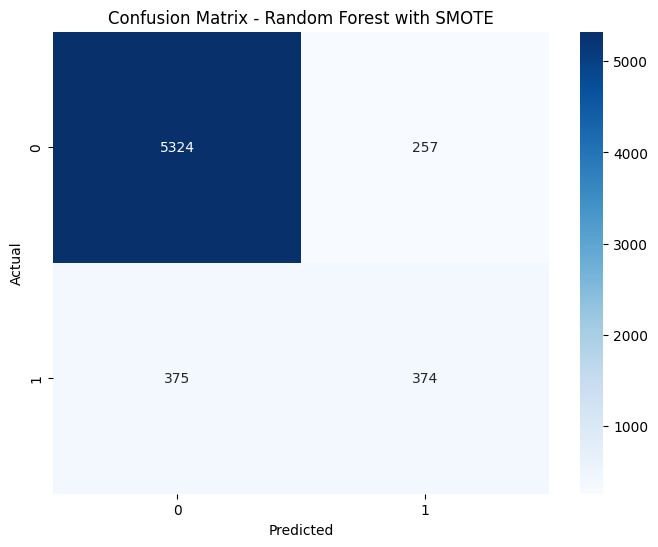

In [50]:
# 1. Random Forest with SMOTE for handling class imbalance
print("\nTraining Random Forest with SMOTE...")
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_f1, rf_precision, rf_recall = evaluate_model(rf_pipeline, X_val, y_val, 'Random Forest with SMOTE')


Training Gradient Boosting...

Gradient Boosting with SMOTE Performance:
F1-Score: 0.6008
Precision: 0.5227
Recall: 0.7063

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      5581
           1       0.52      0.71      0.60       749

    accuracy                           0.89      6330
   macro avg       0.74      0.81      0.77      6330
weighted avg       0.91      0.89      0.90      6330


Confusion Matrix:


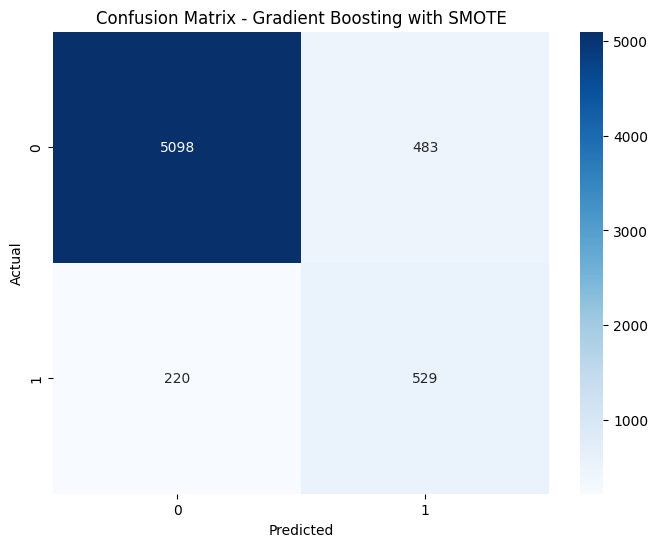

In [51]:
# 2. Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_pipeline.fit(X_train, y_train)
gb_f1, gb_precision, gb_recall = evaluate_model(gb_pipeline, X_val, y_val, 'Gradient Boosting with SMOTE')


Training XGBoost...

XGBoost with SMOTE Performance:
F1-Score: 0.5739
Precision: 0.6314
Recall: 0.5260

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5581
           1       0.63      0.53      0.57       749

    accuracy                           0.91      6330
   macro avg       0.78      0.74      0.76      6330
weighted avg       0.90      0.91      0.90      6330


Confusion Matrix:


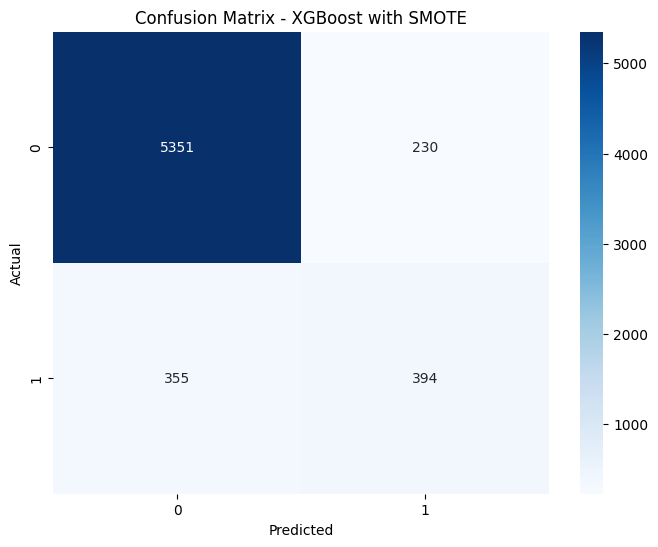

In [52]:
# 3. XGBoost
print("\nTraining XGBoost...")
xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

xgb_pipeline.fit(X_train, y_train)
xgb_f1, xgb_precision, xgb_recall = evaluate_model(xgb_pipeline, X_val, y_val, 'XGBoost with SMOTE')

In [53]:
# Compare model performances
models_performance = {
    'Random Forest': {'F1': rf_f1, 'Precision': rf_precision, 'Recall': rf_recall},
    'Gradient Boosting': {'F1': gb_f1, 'Precision': gb_precision, 'Recall': gb_recall},
    'XGBoost': {'F1': xgb_f1, 'Precision': xgb_precision, 'Recall': xgb_recall}
}

In [55]:
# Find the best model based on F1-score
best_model_name = max(models_performance, key=lambda x: models_performance[x]['F1'])
best_f1 = models_performance[best_model_name]['F1']

print(f"\nBest model based on validation F1-score: {best_model_name} with F1-score of {best_f1:.4f}")


Best model based on validation F1-score: Gradient Boosting with F1-score of 0.6008


In [56]:
# Select the best model pipeline
if best_model_name == 'Random Forest':
    best_pipeline = rf_pipeline
elif best_model_name == 'Gradient Boosting':
    best_pipeline = gb_pipeline
else:
    best_pipeline = xgb_pipeline

## 7. Hyperparameter Tuning for the Best Model

In [57]:
print("\nPerforming hyperparameter tuning for the best model...")


Performing hyperparameter tuning for the best model...


In [58]:
# Define parameter grid based on the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__min_samples_split': [2, 5]
    }
else:  # XGBoost
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__subsample': [0.8, 1.0]
    }

In [59]:
# Create a pipeline for grid search with SMOTE
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=best_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

In [60]:
# Fit grid search
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'duration',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'has_negative_balance',
                                                                          'has_previous_contact',
                                                                          'contact_attempts']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown...
                                                                          'season',
                                                                          'contact_attempt_category',
                                                                          'duration_category',
                                                                          'day_period'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [3, 5],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [61]:
# Get best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation F1-score: 0.5890



Tuned Gradient Boosting Performance:
F1-Score: 0.6008
Precision: 0.5227
Recall: 0.7063

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      5581
           1       0.52      0.71      0.60       749

    accuracy                           0.89      6330
   macro avg       0.74      0.81      0.77      6330
weighted avg       0.91      0.89      0.90      6330


Confusion Matrix:


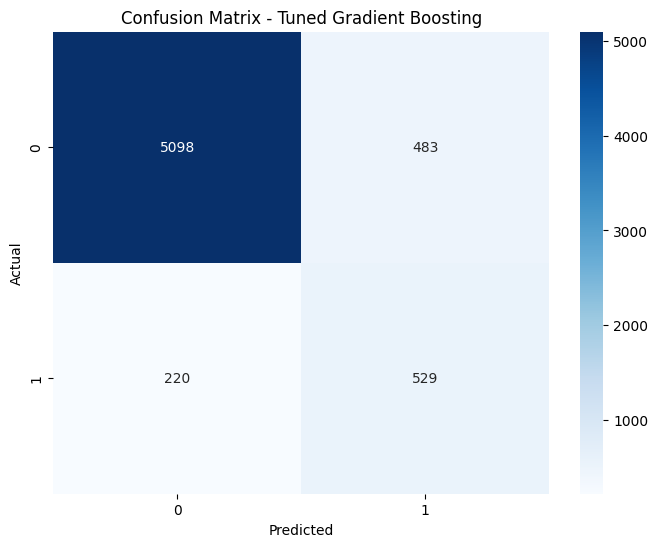

In [62]:
# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
tuned_f1, tuned_precision, tuned_recall = evaluate_model(tuned_model, X_val, y_val, f'Tuned {best_model_name}')

## 8. Feature Importance Analysis

In [63]:
print("\nAnalyzing feature importance...")


Analyzing feature importance...


In [64]:
# Function to extract feature names after one-hot encoding
def get_feature_names(column_transformer):
    output_features = []

    for transformer_name, transformer, column_names in column_transformer.transformers_:
        if transformer == 'drop' or (hasattr(transformer, 'drop') and transformer.drop is not None):
            continue

        if transformer_name == 'num':
            output_features.extend(column_names)
        elif transformer_name == 'cat':
            # Get the encoded feature names
            if hasattr(transformer, 'get_feature_names_out'):
                encoded_names = transformer.get_feature_names_out(column_names)
                output_features.extend(encoded_names)
            else:
                # Handle older versions of sklearn
                encoded_names = [f"{column_names[idx]}_{cat}" for idx, cats in enumerate(transformer.categories_) for cat in cats[1:]]
                output_features.extend(encoded_names)

    return output_features

# Try to get feature importances
try:
    # Extract the preprocessor and classifier from the tuned model
    preprocessor_fitted = tuned_model.named_steps['preprocessor']
    classifier_fitted = tuned_model.named_steps['classifier']

    # Get feature names after transformation
    feature_names = get_feature_names(preprocessor_fitted)

    # Get feature importances
    if hasattr(classifier_fitted, 'feature_importances_'):
        importances = classifier_fitted.feature_importances_

        # Create a dataframe for feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })

        # Sort by importance
        importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

        # Display top features
        print("\nTop 20 important features:")
        display(importance_df.head(20))

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
        plt.title(f'Top 20 Feature Importances - {best_model_name}')
        plt.tight_layout()
        plt.show()
    else:
        print("The selected model doesn't provide feature importances.")
except Exception as e:
    print(f"Could not compute feature importances due to: {str(e)}")

Could not compute feature importances due to: All arrays must be of the same length


## 9. Final Model Training and Prediction

In [65]:
print("\nTraining final model on the full training dataset...")


Training final model on the full training dataset...


In [66]:
# Train the best model on the entire training data
final_model = tuned_model
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'has_negative_balance',
                                                   'has_previous_contact',
                                                   'contact_attempts']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'age_group',
                                                   'balance_category',
                                                   'loan_status',
                                                   'campaign_intensity',
                                                   'season',
                                                   'contact_attempt_category',
                                                   'duration_category',
                                                   'day_period'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [67]:
# Make predictions on the test set
print("\nMaking predictions on the test set...")
X_test = test_df_eng[all_features]
test_predictions = final_model.predict(X_test)


Making predictions on the test set...


In [68]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'Target': test_predictions
})

In [69]:
# Save submission file
submission_file = 'submission_updated.csv'
submission_df.to_csv(submission_file, index=False)
print(f"\nSubmission file saved as {submission_file}")


Submission file saved as submission_updated.csv


In [70]:


# 10. Summary of the approach
print("\n" + "="*50)
print("SUMMARY OF APPROACH AND RESULTS")
print("="*50)
print(f"Best model: {best_model_name}")
print(f"F1-Score on validation data: {tuned_f1:.4f}")
print(f"Precision on validation data: {tuned_precision:.4f}")
print(f"Recall on validation data: {tuned_recall:.4f}")
print("\nKey steps in the approach:")
print("1. Extensive exploratory data analysis")
print("2. Feature engineering to create informative features")
print("3. Preprocessing with standardization for numerical and one-hot encoding for categorical features")
print("4. Handling class imbalance using SMOTE")
print("5. Model comparison (Random Forest, Gradient Boosting, XGBoost)")
print("6. Hyperparameter tuning using GridSearchCV")
print("7. Feature importance analysis")
print("8. Final prediction and submission file creation")
print("="*50)


SUMMARY OF APPROACH AND RESULTS
Best model: Gradient Boosting
F1-Score on validation data: 0.6008
Precision on validation data: 0.5227
Recall on validation data: 0.7063

Key steps in the approach:
1. Extensive exploratory data analysis
2. Feature engineering to create informative features
3. Preprocessing with standardization for numerical and one-hot encoding for categorical features
4. Handling class imbalance using SMOTE
5. Model comparison (Random Forest, Gradient Boosting, XGBoost)
6. Hyperparameter tuning using GridSearchCV
7. Feature importance analysis
8. Final prediction and submission file creation
